<a href="https://colab.research.google.com/github/RuishiCh-git/Open-Close-Eye-Detection/blob/main/OpenCloseEyesDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

# Face & Eye Detection

In [ ]:
# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# load model
model = YOLO(model_path)

# inference
image_path = "/content/drive/My Drive/Academics/EDUC463/Face/Closed/0.jpg"
output = model(Image.open(image_path))
results = Detections.from_ultralytics(output[0])


0: 640x640 1 FACE, 287.3ms
Speed: 4.0ms preprocess, 287.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
results

Detections(xyxy=array([[     27.478,      92.255,       124.2,      207.66]], dtype=float32), mask=None, confidence=array([    0.88808], dtype=float32), class_id=array([0]), tracker_id=None, data={})

# Open & Close Eye Detection

## Read in Data

In [ ]:
drive_root = "/content/drive/My Drive/Academics/EDUC463/TrainingSet"
print(os.listdir(drive_root))

['Closed', 'Opened', 'model.png']


In [ ]:
train_directory_path = "/content/drive/My Drive/Academics/EDUC463/TestSet"
test_directory_path = "/content/drive/My Drive/Academics/EDUC463/TrainingSet"
val_directory_path="/content/drive/My Drive/Academics/EDUC463/ImprovementSet"

In [ ]:
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory_path,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4232 files belonging to 2 classes.
Found 1704 files belonging to 2 classes.
Found 4103 files belonging to 2 classes.


## Process Data

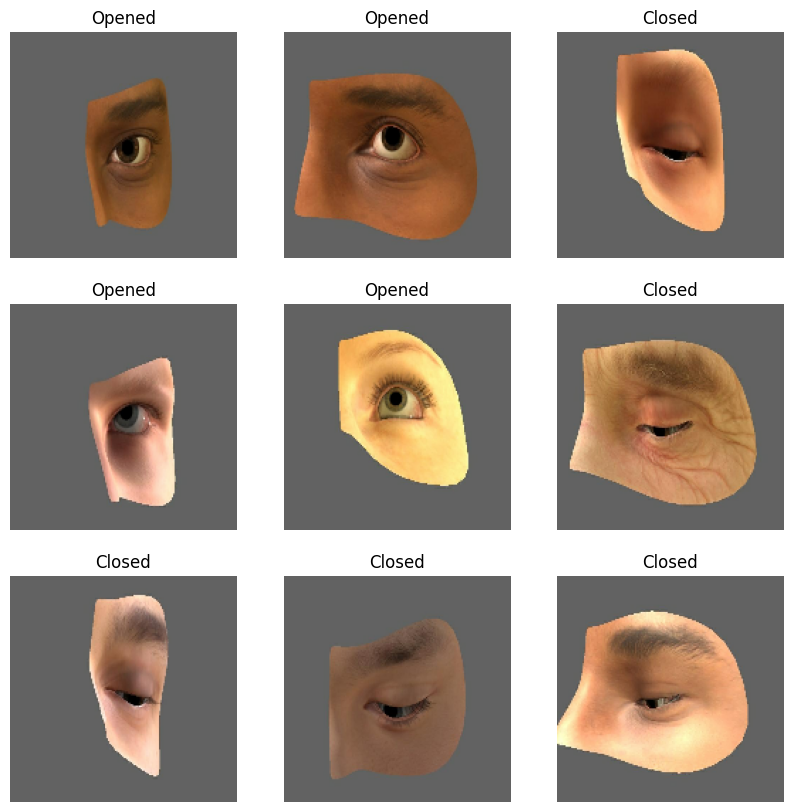

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 129
Number of test batches: 54


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction

In [ ]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

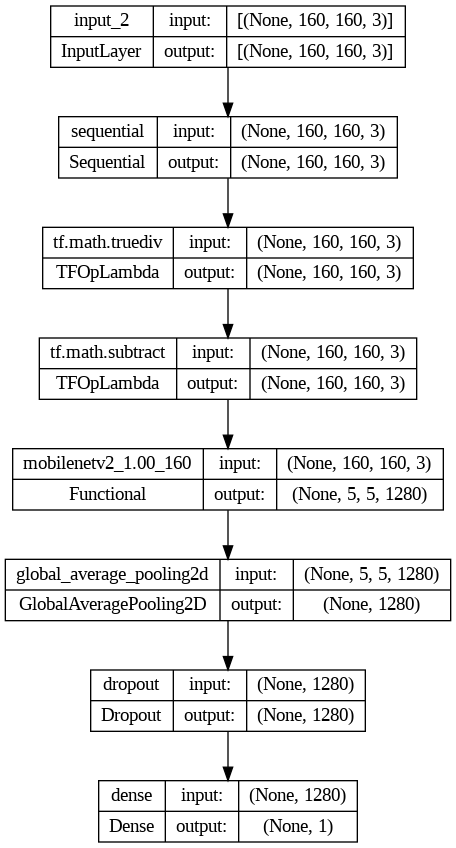

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile the Model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

129/129 [==============================] - 483s 3s/step - loss: 1.3020 - accuracy: 0.4706


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.30
initial accuracy: 0.47


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
133/133 [==============================] - 363s 3s/step - loss: 0.7024 - accuracy: 0.5992 - val_loss: 0.6245 - val_accuracy: 0.6442
Epoch 2/10
133/133 [==============================] - 179s 1s/step - loss: 0.5142 - accuracy: 0.7535 - val_loss: 0.4936 - val_accuracy: 0.7548
Epoch 3/10
133/133 [==============================] - 179s 1s/step - loss: 0.4258 - accuracy: 0.8202 - val_loss: 0.4133 - val_accuracy: 0.8131
Epoch 4/10
133/133 [==============================] - 174s 1s/step - loss: 0.3665 - accuracy: 0.8518 - val_loss: 0.3614 - val_accuracy: 0.8494
Epoch 5/10
133/133 [==============================] - 174s 1s/step - loss: 0.3303 - accuracy: 0.8705 - val_loss: 0.3343 - val_accuracy: 0.8650
Epoch 6/10
133/133 [==============================] - 175s 1s/step - loss: 0.3092 - accuracy: 0.8795 - val_loss: 0.3088 - val_accuracy: 0.8772
Epoch 7/10
133/133 [==============================] - 242s 2s/step - loss: 0.2878 - accuracy: 0.8913 - val_loss: 0.2976 - val_accuracy: 0.8823

### Learning Curve

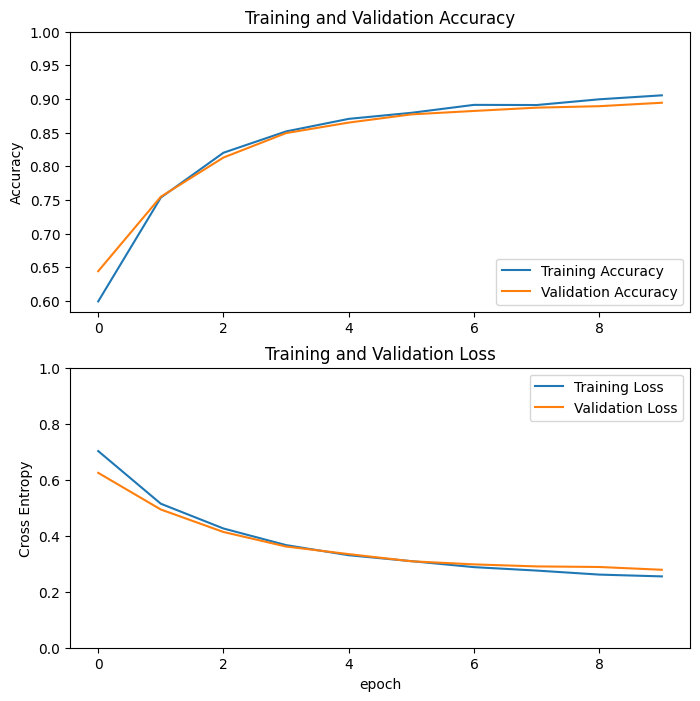

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue Training

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
133/133 [==============================] - 233s 2s/step - loss: 0.1393 - accuracy: 0.9480 - val_loss: 0.2432 - val_accuracy: 0.9237
Epoch 11/20
133/133 [==============================] - 225s 2s/step - loss: 0.1348 - accuracy: 0.9497 - val_loss: 0.2392 - val_accuracy: 0.9232
Epoch 12/20
133/133 [==============================] - 284s 2s/step - loss: 0.1274 - accuracy: 0.9544 - val_loss: 0.2439 - val_accuracy: 0.9244
Epoch 13/20
133/133 [==============================] - 289s 2s/step - loss: 0.1207 - accuracy: 0.9539 - val_loss: 0.2163 - val_accuracy: 0.9325
Epoch 14/20
133/133 [==============================] - 292s 2s/step - loss: 0.1087 - accuracy: 0.9589 - val_loss: 0.2669 - val_accuracy: 0.9281
Epoch 15/20
133/133 [==============================] - 232s 2s/step - loss: 0.1132 - accuracy: 0.9568 - val_loss: 0.2215 - val_accuracy: 0.9366
Epoch 16/20
133/133 [==============================] - 235s 2s/step - loss: 0.1085 - accuracy: 0.9601 - val_loss: 0.2280 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

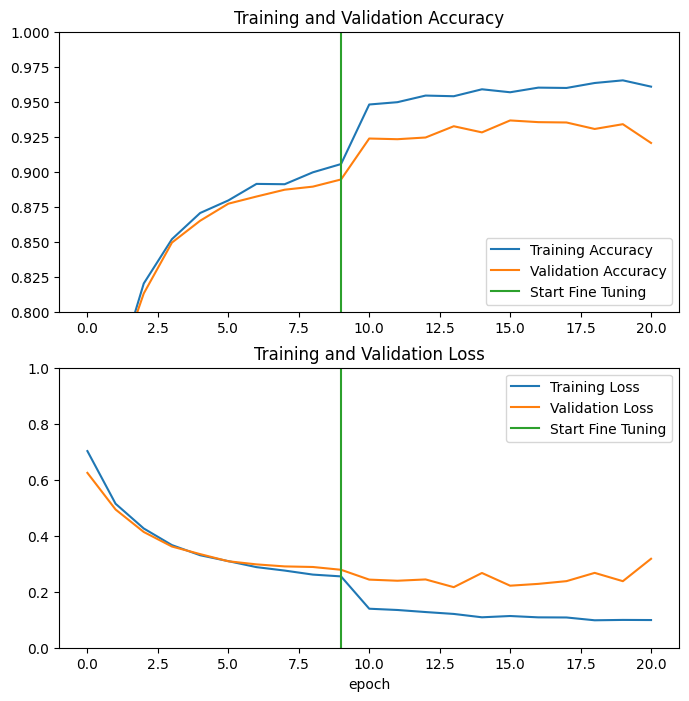

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

54/54 [==============================] - 204s 3s/step - loss: 0.1992 - accuracy: 0.9401
Test accuracy : 0.9401408433914185


Predictions:
 [0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1]
Labels:
 [0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1]


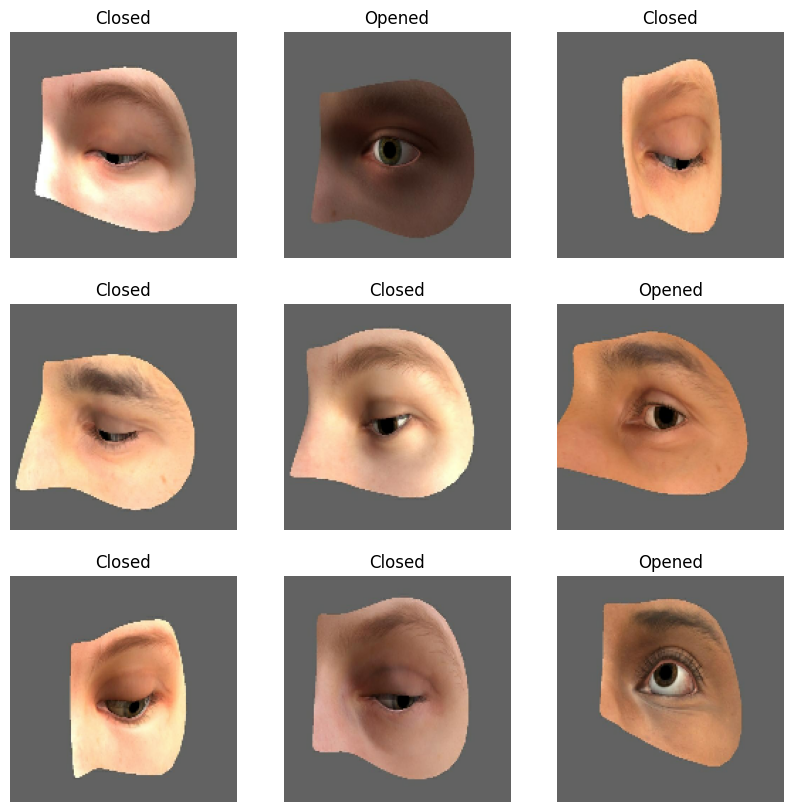

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")